Load All Records

In [6]:
import wfdb
import pandas as pd

record_ids = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109'  # Add more if available
]

all_records = []

for record_id in record_ids:
    try:
        record = wfdb.rdrecord(f"../Data/{record_id}")
        annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')
        all_records.append({
            "record_id": record_id,
            "fs": record.fs,
            "n_samples": record.sig_len,
            "n_channels": record.n_sig,
            "annotations": annotation.sample
        })
        print(f"Loaded {record_id}")
    except Exception as e:
        print(f"Error loading {record_id}: {e}")

# Create summary DataFrame
summary = []

for rec in all_records:
    summary.append({
        "ID": rec["record_id"],
        "Sampling Rate (Hz)": rec["fs"],
        "Total Samples": rec["n_samples"],
        "Channels": rec["n_channels"],
        "Beats Detected": len(rec["annotations"])
    })
# Extracted metadata is stored as a DataFrame for better visualization
df_summary = pd.DataFrame(summary)
print(df_summary)


Loaded 100
Loaded 101
Loaded 102
Loaded 103
Loaded 104
Loaded 105
Loaded 106
Loaded 107
Loaded 108
Loaded 109
    ID  Sampling Rate (Hz)  Total Samples  Channels  Beats Detected
0  100                 360         650000         2            2274
1  101                 360         650000         2            1874
2  102                 360         650000         2            2192
3  103                 360         650000         2            2091
4  104                 360         650000         2            2311
5  105                 360         650000         2            2691
6  106                 360         650000         2            2098
7  107                 360         650000         2            2140
8  108                 360         650000         2            1824
9  109                 360         650000         2            2535


In [12]:
import wfdb
import wfdb

record = wfdb.rdrecord("../Data/100")   # no .dat
ann = wfdb.rdann("../Data/100", "atr")

print("p_signal shape:", record.p_signal.shape)
print("fs:", record.fs)
print("ann samples:", len(ann.sample))
print("example symbols:", sorted(set(ann.symbol))[:20])


p_signal shape: (650000, 2)
fs: 360
ann samples: 2274
example symbols: ['+', 'A', 'N', 'V']


##### Result is gonna look like this 
__p_signal shape__: (650000, 2)    
__fs__: 360     
__ann samples__: 2274   
__example symbols__: ['+', 'A', 'N', 'V']   

1. Number of samples taken and number of channels
2. These many samples taken in one second - for each patients 30 minutes long ECG 
3. These many points where beats occured  
4. For each heart beat what kind of beat it is 
- 'N' → Normal beat
- 'A' → Atrial premature beat(APB)
- 'V' → Ventricular ectopic beat
- '+' → Segment marker

Beat type distribution

In [8]:
import wfdb
from collections import Counter
import os

# Path to your MIT-BIH data folder
data_path = "../Data"

# For a single record
record_id = "232"  # change to your record number
ann = wfdb.rdann(f"{data_path}/{record_id}", 'atr')
counts = Counter(ann.symbol)
print(f"Distribution for record {record_id}:")
for sym, cnt in counts.items():
    print(f"{sym}: {cnt}")

# -----------------------------
# For all records in your folder
all_counts = Counter()

for file in os.listdir(data_path):
    if file.endswith(".atr"):
        rec_name = file.split(".")[0]
        ann = wfdb.rdann(f"{data_path}/{rec_name}", 'atr')
        all_counts.update(ann.symbol)

print("\nOverall distribution across dataset:")
for sym, cnt in sorted(all_counts.items(), key=lambda x: -x[1]):
    print(f"{sym}: {cnt}")


Distribution for record 232:
+: 1
R: 397
A: 1382
~: 35
j: 1

Overall distribution across dataset:
N: 75052
L: 8075
R: 7259
V: 7130
/: 7028
A: 2546
+: 1291
f: 982
F: 803
~: 616
!: 472
": 437
j: 229
x: 193
a: 150
|: 132
E: 106
J: 83
Q: 33
e: 16
[: 6
]: 6
S: 2


Code to Extract All Header Features

In [10]:
import wfdb

# Load the header only (no signal data)
record_id = "../Data/100"  # Change to your file
header = wfdb.rdheader(record_id)

# Convert header object to dictionary
header_info = header.__dict__

# Print all features and their values
print("=== Header Metadata ===")
for key, value in header_info.items():
    print(f"{key}: {value}")


=== Header Metadata ===
record_name: 100
n_sig: 2
fs: 360
counter_freq: None
base_counter: None
sig_len: 650000
base_time: None
base_date: None
comments: []
sig_name: ['MLII', 'V5']
p_signal: None
d_signal: None
e_p_signal: None
e_d_signal: None
file_name: ['100.dat', '100.dat']
fmt: ['212', '212']
samps_per_frame: [1, 1]
skew: [None, None]
byte_offset: [None, None]
adc_gain: [986.3720073664825, 1109.127789046653]
baseline: [631, 687]
units: ['mV', 'mV']
adc_res: [12, 12]
adc_zero: [0, 0]
init_value: [488, 615]
checksum: [49741, 25326]
block_size: [0, 0]


Visualize ECG Sample for one patient at a time

For Ventricular ectopic(V) beat

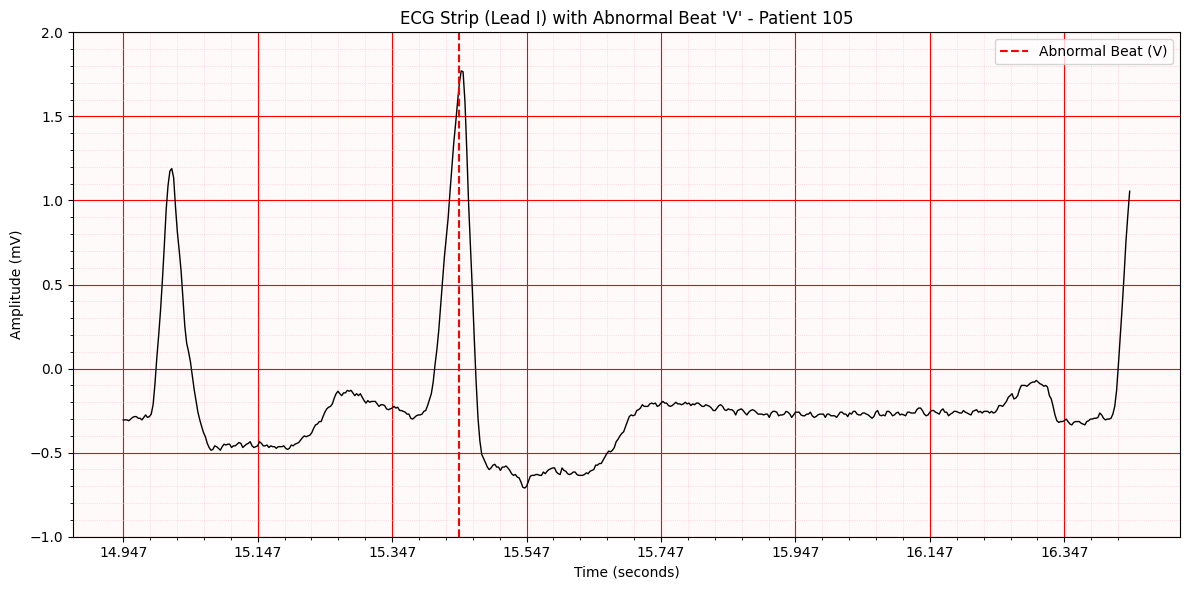

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with abnormal beats
record_id = "105"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'V' beat
No_beat_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'V']

if No_beat_indices:
    idx = No_beat_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Abnormal Beat (V)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Abnormal Beat 'V' - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'V' found in patient {record_id}.")


For Normal(N) beat

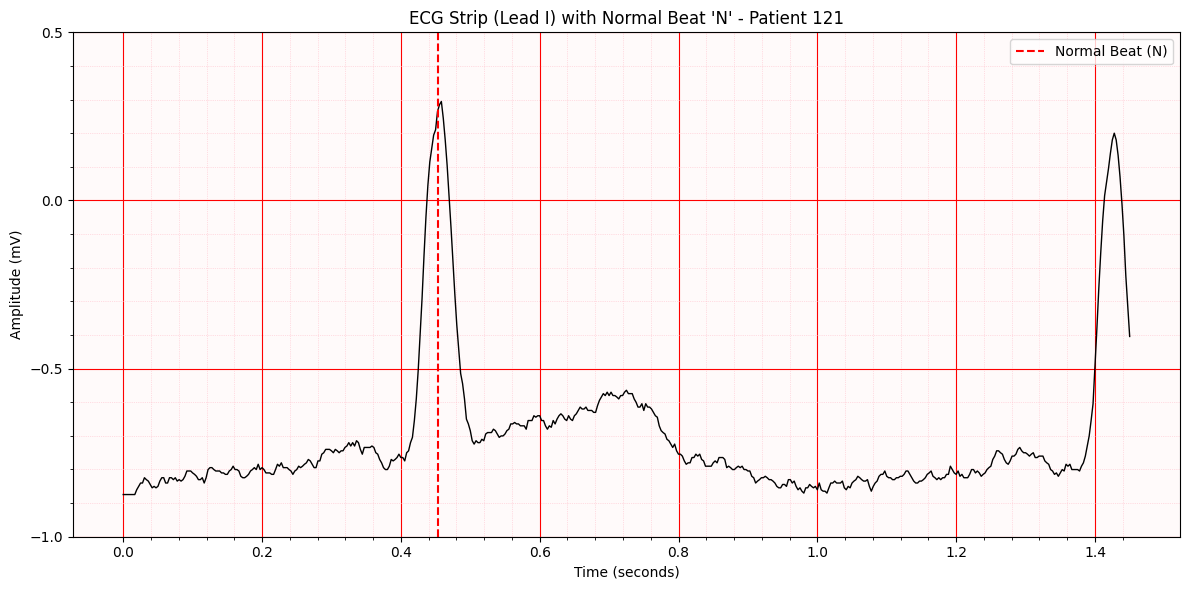

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with Normal beats
record_id = "121"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'N' beat
No_beat_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'N']

if No_beat_indices:
    idx = No_beat_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Normal Beat (N)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Normal Beat 'N' - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'N' found in patient {record_id}.")


For  Atrial premature beat(APB)(A)  beat

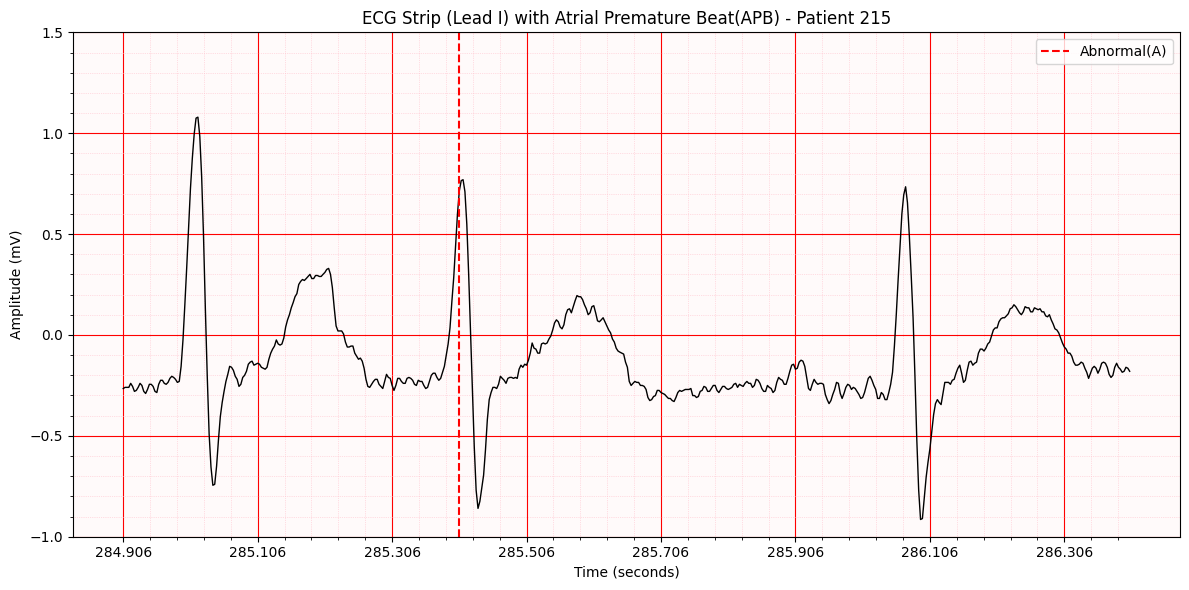

In [5]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with No beats
record_id = "215"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'A' beat
No_beat_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'A']

if No_beat_indices:
    idx = No_beat_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Abnormal(A)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Atrial Premature Beat(APB) - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No signal artifact beat 'A' found in patient {record_id}.")

For No Beat

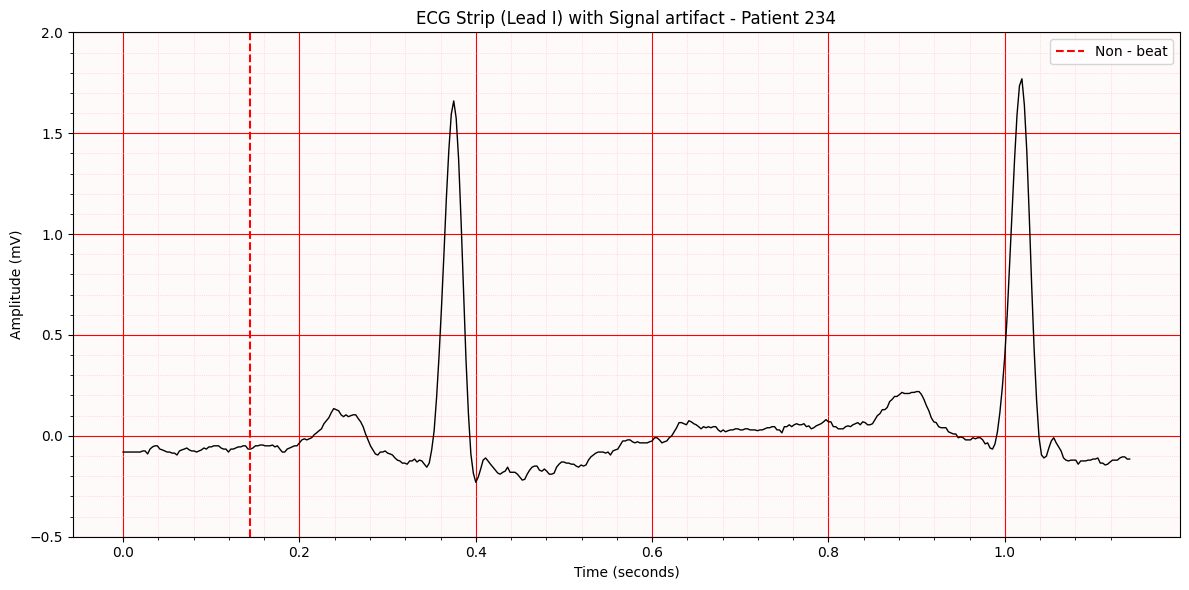

In [6]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with No beats
record_id = "234"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first '+' beat
No_beat_indices = [i for i, sym in enumerate(annotation.symbol) if sym == '+']

if No_beat_indices:
    idx = No_beat_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Non - beat")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Signal artifact - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No signal artifact beat '+' found in patient {record_id}.")


For R beat

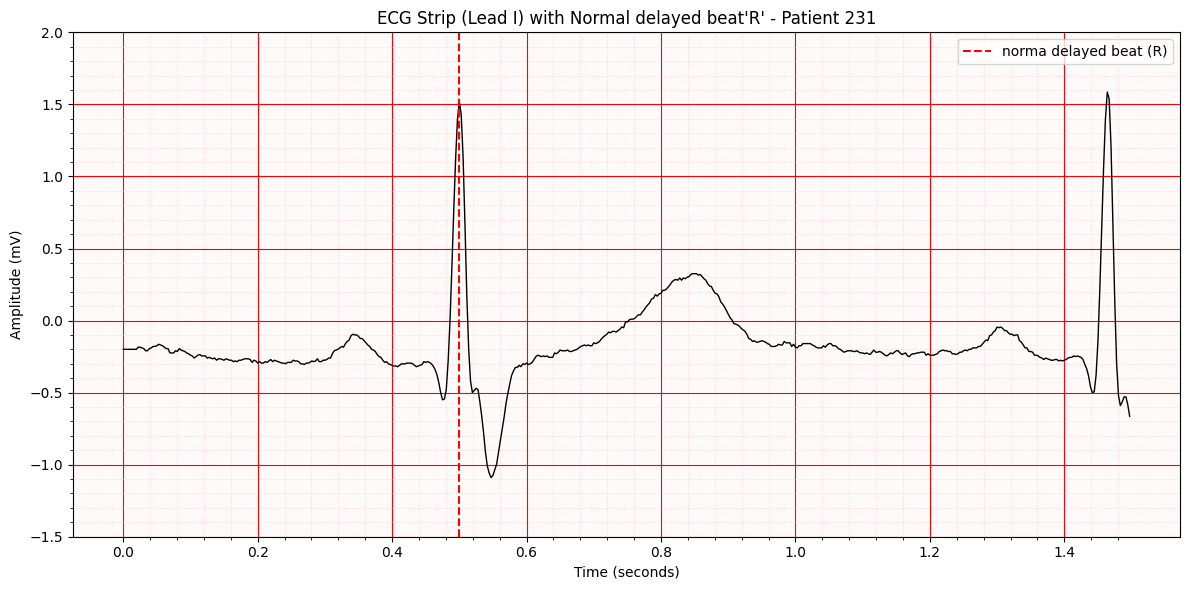

In [5]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with abnormal beats
record_id = "231"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'R' beat
No_beat_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'R']

if No_beat_indices:
    idx = No_beat_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="norma delayed beat (R)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Normal delayed beat'R' - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'R' found in patient {record_id}.")


Annotation summary for each patient

In [7]:
from collections import Counter
import wfdb

# Load record and annotations (use 'atr' for arrhythmia labels)
record_id = "100"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", "atr")

# Summary
print("Total annotations:", len(annotation.sample))
print("Unique symbols:", sorted(set(annotation.symbol)))
print("Counts:", Counter(annotation.symbol).most_common())

# Show first 20 annotations (symbol, sample index, time in seconds)
print("\nFirst 20 annotations:")
for symbol, sample in zip(annotation.symbol[:20], annotation.sample[:20]):
    time_sec = sample / record.fs
    print(f"{symbol:3}  {sample:6}  {time_sec:8.3f} sec")


Total annotations: 2274
Unique symbols: ['+', 'A', 'N', 'V']
Counts: [('N', 2239), ('A', 33), ('+', 1), ('V', 1)]

First 20 annotations:
+        18     0.050 sec
N        77     0.214 sec
N       370     1.028 sec
N       662     1.839 sec
N       946     2.628 sec
N      1231     3.419 sec
N      1515     4.208 sec
N      1809     5.025 sec
A      2044     5.678 sec
N      2402     6.672 sec
N      2706     7.517 sec
N      2998     8.328 sec
N      3282     9.117 sec
N      3560     9.889 sec
N      3862    10.728 sec
N      4170    11.583 sec
N      4466    12.406 sec
N      4764    13.233 sec
N      5060    14.056 sec
N      5346    14.850 sec


RR intervals and basic heart-rate stats  
Plot RR histogram or RR time series to detect pauses, tachy/bradycardia, or ectopy bursts

In [8]:
import numpy as np

# define set of symbols you consider "beats" (adjust if needed)
beat_symbols = set(['N','L','R','A','a','J','S','V','F','e','j','E','/','f','Q'])
# filter annotation samples whose symbol is in beat_symbols
beat_samples = np.array([s for s,sym in zip(annotation.sample, annotation.symbol) if sym in beat_symbols])
rr_samples = np.diff(beat_samples)                # in samples
rr_seconds = rr_samples / record.fs              # in seconds
print("N beats found:", len(beat_samples))
print("RR mean (s):", rr_seconds.mean())
print("RR std (s):", rr_seconds.std())
print("Median HR (bpm):", np.median(60 / rr_seconds))


N beats found: 2273
RR mean (s): 0.794593603286385
RR std (s): 0.04883539560305964
Median HR (bpm): 75.26132404181185
